In [1]:
!pip install transformers torch pandas scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve

In [4]:

df = pd.read_json('/content/drive/MyDrive/megavul_simple.json')

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353873 entries, 0 to 353872
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cve_id                  353873 non-null  object 
 1   cwe_ids                 353873 non-null  object 
 2   cvss_vector             353778 non-null  object 
 3   cvss_is_v3              353778 non-null  float64
 4   repo_name               353873 non-null  object 
 5   commit_msg              353873 non-null  object 
 6   commit_hash             353873 non-null  object 
 7   git_url                 353873 non-null  object 
 8   file_path               353873 non-null  object 
 9   func_name               353873 non-null  object 
 10  func_before             17975 non-null   object 
 11  abstract_func_before    17975 non-null   object 
 12  func_graph_path_before  15664 non-null   object 
 13  func                    353873 non-null  object 
 14  abstract_func       

In [6]:

df.head()

,cve_id,cwe_ids,cvss_vector,cvss_is_v3,repo_name,commit_msg,commit_hash,git_url,file_path,func_name,func_before,abstract_func_before,func_graph_path_before,func,abstract_func,func_graph_path,diff_func,diff_line_info,is_vul
0,CVE-2016-2538,[CWE-189],AV:L/AC:L/Au:N/C:P/I:N/A:P,0.0,qemu,usb: check RNDIS buffer offsets & length\n\nWh...,fe3c546c5ff2a6210f9a4d8561cc64051ca8603e,https://github.com/qemu/qemu/commit/fe3c546c5f...,hw/usb/dev-network.c,rndis_query_response,static int rndis_query_response(USBNetState *s...,static int rndis_query_response(USBNetState *V...,qemu/fe3c546c5ff2a6210f9a4d8561cc64051ca8603e/...,static int rndis_query_response(USBNetState *s...,static int rndis_query_response(USBNetState *V...,qemu/fe3c546c5ff2a6210f9a4d8561cc64051ca8603e/...,"--- func_before\n+++ func_after\n@@ -10,8 +10,...",{'deleted_lines': [' if (bufoffs + buflen >...,True
1,CVE-2016-2538,[CWE-189],AV:L/AC:L/Au:N/C:P/I:N/A:P,0.0,qemu,usb: check RNDIS buffer offsets & length\n\nWh...,fe3c546c5ff2a6210f9a4d8561cc64051ca8603e,https://github.com/qemu/qemu/commit/fe3c546c5f...,hw/usb/dev-network.c,rndis_set_response,"static int rndis_set_response(USBNetState *s,\...",static int rndis_set_response(USBNetState *VAR...,qemu/fe3c546c5ff2a6210f9a4d8561cc64051ca8603e/...,"static int rndis_set_response(USBNetState *s,\...",static int rndis_set_response(USBNetState *VAR...,qemu/fe3c546c5ff2a6210f9a4d8561cc64051ca8603e/...,"--- func_before\n+++ func_after\n@@ -11,8 +11,...",{'deleted_lines': [' if (bufoffs + buflen >...,True
2,CVE-2016-2538,[CWE-189],AV:L/AC:L/Au:N/C:P/I:N/A:P,0.0,qemu,usb: check RNDIS buffer offsets & length\n\nWh...,fe3c546c5ff2a6210f9a4d8561cc64051ca8603e,https://github.com/qemu/qemu/commit/fe3c546c5f...,hw/usb/dev-network.c,usb_net_handle_dataout,static void usb_net_handle_dataout(USBNetState...,static void usb_net_handle_dataout(USBNetState...,qemu/fe3c546c5ff2a6210f9a4d8561cc64051ca8603e/...,static void usb_net_handle_dataout(USBNetState...,static void usb_net_handle_dataout(USBNetState...,qemu/fe3c546c5ff2a6210f9a4d8561cc64051ca8603e/...,"--- func_before\n+++ func_after\n@@ -30,8 +30,...",{'deleted_lines': [' if (offs + size <=...,True
3,CVE-2016-2841,[CWE-20],AV:L/AC:L/Au:N/C:N/I:N/A:P,0.0,qemu,net: ne2000: check ring buffer control registe...,415ab35a441eca767d033a2702223e785b9d5190,https://github.com/qemu/qemu/commit/415ab35a44...,hw/net/ne2000.c,ne2000_buffer_full,static int ne2000_buffer_full(NE2000State *s)\...,static int ne2000_buffer_full(NE2000State *VAR...,qemu/415ab35a441eca767d033a2702223e785b9d5190/...,static int ne2000_buffer_full(NE2000State *s)\...,static int ne2000_buffer_full(NE2000State *VAR...,qemu/415ab35a441eca767d033a2702223e785b9d5190/...,"--- func_before\n+++ func_after\n@@ -1,6 +1,10...","{'deleted_lines': [], 'added_lines': ['', ' ...",True
4,CVE-2016-2841,[CWE-20],AV:L/AC:L/Au:N/C:N/I:N/A:P,0.0,qemu,net: ne2000: check ring buffer control registe...,415ab35a441eca767d033a2702223e785b9d5190,https://github.com/qemu/qemu/commit/415ab35a44...,hw/net/ne2000.c,ne2000_mem_readl,None,None,None,static inline uint32_t ne2000_mem_readl(NE2000...,static inline uint32_t ne2000_mem_readl(NE2000...,qemu/415ab35a441eca767d033a2702223e785b9d5190/...,None,None,False


In [7]:
df.isnull().sum()

,0
cve_id,0
cwe_ids,0
cvss_vector,95
cvss_is_v3,95
repo_name,0
commit_msg,0
commit_hash,0
git_url,0
file_path,0
func_name,0


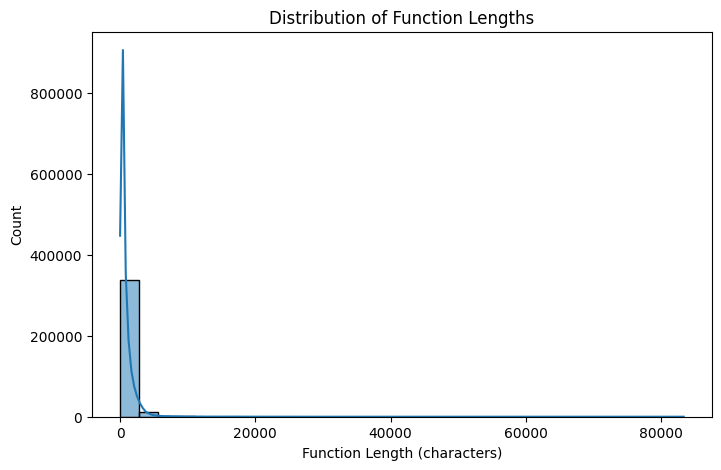

In [ ]:
df["function_length"] = df["func"].apply(lambda x: len(str(x)))

plt.figure(figsize=(8, 5))
sns.histplot(df["function_length"], bins=30, kde=True)
plt.xlabel("Function Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Function Lengths")
plt.show()

In [ ]:
for col in df.columns[:-1]:  # Excluding the last column
    print(f"{col}: {df[col].apply(type).value_counts()}")


cve_id: cve_id
<class 'str'>    353873
Name: count, dtype: int64
cwe_ids: cwe_ids
<class 'list'>    353873
Name: count, dtype: int64
cvss_vector: cvss_vector
<class 'str'>         353778
<class 'NoneType'>        95
Name: count, dtype: int64
cvss_is_v3: cvss_is_v3
<class 'float'>    353873
Name: count, dtype: int64
repo_name: repo_name
<class 'str'>    353873
Name: count, dtype: int64
commit_msg: commit_msg
<class 'str'>    353873
Name: count, dtype: int64
commit_hash: commit_hash
<class 'str'>    353873
Name: count, dtype: int64
git_url: git_url
<class 'str'>    353873
Name: count, dtype: int64
file_path: file_path
<class 'str'>    353873
Name: count, dtype: int64
func_name: func_name
<class 'str'>    353873
Name: count, dtype: int64
func_before: func_before
<class 'NoneType'>    335898
<class 'str'>          17975
Name: count, dtype: int64
abstract_func_before: abstract_func_before
<class 'NoneType'>    335898
<class 'str'>          17975
Name: count, dtype: int64
func_graph_path_bef

In [ ]:
df.shape

(353873, 20)

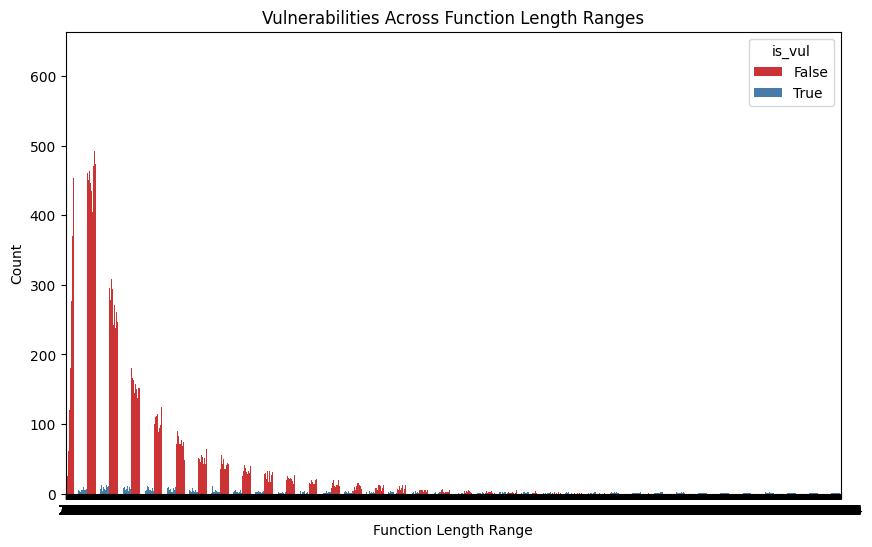

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='function_length', hue='is_vul', data=df, palette='Set1')
plt.title('Vulnerabilities Across Function Length Ranges')
plt.xlabel('Function Length Range')
plt.ylabel('Count')
plt.show()

In [9]:
# CodeBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

def get_embedding(code):
    inputs = tokenizer(code, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# # first 1000 rows
# subset_df = df.head(1000)
# embeddings = subset_df['func'].apply(get_embedding)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
subset_size = 1000

features = []
labels = []

# Processing each repository
for repo_name, repo_df in df.groupby('repo_name'):
    commit_counter = 0
    file_stats = {}     # {file_path: {'last_vul_commit': int/None, 'cum_vul_count': int, 'commit_count': int}}
    repo_last_vul_commit = None  # Tracks last vulnerability commit in repo


    for commit_hash, commit_df in repo_df.groupby('commit_hash'):
        commit_counter += 1
        has_vul = commit_df['is_vul'].sum() > 0
        if has_vul:
            repo_last_vul_commit = commit_counter

        file_groups = commit_df.groupby('file_path')
        for file_path, file_df in file_groups:
            if file_path not in file_stats:
                file_stats[file_path] = {'last_vul_commit': None, 'cum_vul_count': 0, 'commit_count': 0}

            last_vul_commit = file_stats[file_path]['last_vul_commit']
            past_vul_count = file_stats[file_path]['cum_vul_count']
            commit_count = file_stats[file_path]['commit_count']

            file_commits_since_last_vul = commit_counter - last_vul_commit if last_vul_commit is not None else 10000
            repo_commits_since_last_vul = commit_counter - repo_last_vul_commit if repo_last_vul_commit is not None else 10000

            for idx, row in file_df.iterrows():
                features.append({
                    'past_vul_count': past_vul_count,
                    'commit_count': commit_count,
                    'file_commits_since_last_vul': file_commits_since_last_vul,
                    'repo_commits_since_last_vul': repo_commits_since_last_vul
                })
                labels.append(row['is_vul'])

            num_vul_this_commit = file_df['is_vul'].sum()
            if num_vul_this_commit > 0:
                file_stats[file_path]['last_vul_commit'] = commit_counter
            file_stats[file_path]['cum_vul_count'] += num_vul_this_commit
            file_stats[file_path]['commit_count'] += 1


In [11]:

# feature DataFrame
feature_df = pd.DataFrame(features)
feature_df['label'] = labels
print("Temporal features generated:")
print(feature_df.head())



Temporal features generated:
   past_vul_count  commit_count  file_commits_since_last_vul  \
0               0             0                        10000   
1               0             0                        10000   
2               0             0                        10000   
3               0             0                        10000   
4               0             0                        10000   

   repo_commits_since_last_vul  label  
0                            0   True  
1                            0   True  
2                            0  False  
3                            0  False  
4                            0  False  


In [12]:
feature_df['commit_count'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [13]:
feature_df['past_vul_count'].unique()

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10,  4, 12, 11, 13, 14, 15, 16,
       18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 17, 26,
       34, 36, 37, 38, 39, 41, 43, 45, 40, 46, 42, 47, 49, 50, 51, 52, 53,
       54, 56, 44, 62, 95, 99, 35, 55, 57, 59])

In [14]:
# Stratified sampling based on 'is_vul' coloumn
subset_df = df.groupby('is_vul', group_keys=False).apply(lambda x: x.sample(min(len(x), subset_size // 2)))
subset_indices = subset_df.index

# Computing embeddings for 'func'
embeddings = subset_df['func'].apply(get_embedding)
embedding_array = np.stack(embeddings.values)
print(f"Embedding shape: {embedding_array.shape}")


<ipython-input-14-3c842446ef22>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = df.groupby('is_vul', group_keys=False).apply(lambda x: x.sample(min(len(x), subset_size // 2)))


Embedding shape: (1000, 768)


In [15]:

# Extract corresponding temporal features and labels
X_temporal_subset = feature_df.loc[subset_indices, ['past_vul_count', 'commit_count',
                                                  'file_commits_since_last_vul', 'repo_commits_since_last_vul']]
y_subset = feature_df.loc[subset_indices, 'label']

# Check label distribution
print("Label distribution in full dataset:")
print(df['is_vul'].value_counts(normalize=True))
print("Label distribution in subset:")
print(y_subset.value_counts(normalize=True))


Label distribution in full dataset:
is_vul
False    0.949205
True     0.050795
Name: proportion, dtype: float64
Label distribution in subset:
label
False    0.957
True     0.043
Name: proportion, dtype: float64


In [16]:

# reduce dimensionality
pca = PCA(n_components=50, random_state=42)
X_code_reduced = pca.fit_transform(embedding_array)

# Scaling features
scaler = StandardScaler()
X_code_scaled = scaler.fit_transform(X_code_reduced)
X_temporal_scaled = scaler.fit_transform(X_temporal_subset)
X_combined = np.hstack((X_temporal_scaled, X_code_scaled))

# SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_combined_balanced, y_subset_balanced = smote.fit_resample(X_combined, y_subset)


X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(
    X_combined_balanced, y_subset_balanced, test_size=0.2, random_state=42
)

# combined features model
clf_combined = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_combined.fit(X_combined_train, y_combined_train)
y_pred_combined = clf_combined.predict(X_combined_test)

metrics_combined = {
    'Precision': precision_score(y_combined_test, y_pred_combined),
    'Recall': recall_score(y_combined_test, y_pred_combined),
    'F1-score': f1_score(y_combined_test, y_pred_combined),
    'ROC-AUC': roc_auc_score(y_combined_test, clf_combined.predict_proba(X_combined_test)[:, 1])
}

# Code-only model
X_code_train, X_code_test, y_code_train, y_code_test = train_test_split(
    X_code_scaled, y_subset, test_size=0.2, random_state=42
)
clf_code = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_code.fit(X_code_train, y_code_train)
y_pred_code = clf_code.predict(X_code_test)
metrics_code = {
    'Precision': precision_score(y_code_test, y_pred_code),
    'Recall': recall_score(y_code_test, y_pred_code),
    'F1-score': f1_score(y_code_test, y_pred_code),
    'ROC-AUC': roc_auc_score(y_code_test, clf_code.predict_proba(X_code_test)[:, 1])
}

# Temporal-only model
X_temporal_train, X_temporal_test, y_temporal_train, y_temporal_test = train_test_split(
    X_temporal_scaled, y_subset, test_size=0.2, random_state=42
)
clf_temporal = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_temporal.fit(X_temporal_train, y_temporal_train)
y_pred_temporal = clf_temporal.predict(X_temporal_test)
metrics_temporal = {
    'Precision': precision_score(y_temporal_test, y_pred_temporal),
    'Recall': recall_score(y_temporal_test, y_pred_temporal),
    'F1-score': f1_score(y_temporal_test, y_pred_temporal),
    'ROC-AUC': roc_auc_score(y_temporal_test, clf_temporal.predict_proba(X_temporal_test)[:, 1])
}



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# Print evaluation results
print("\nModel Performance Comparison:")
print("----------------------------")
print("Combined Features:")
print(f"Precision: {metrics_combined['Precision']:.4f}, Recall: {metrics_combined['Recall']:.4f}, "
      f"F1-score: {metrics_combined['F1-score']:.4f}, ROC-AUC: {metrics_combined['ROC-AUC']:.4f}")
print("Predictions:", np.unique(y_pred_combined, return_counts=True))

print("\nCode Features Only:")
print(f"Precision: {metrics_code['Precision']:.4f}, Recall: {metrics_code['Recall']:.4f}, "
      f"F1-score: {metrics_code['F1-score']:.4f}, ROC-AUC: {metrics_code['ROC-AUC']:.4f}")
print("Predictions:", np.unique(y_pred_code, return_counts=True))


print("\nTemporal Features Only:")
print(f"Precision: {metrics_temporal['Precision']:.4f}, Recall: {metrics_temporal['Recall']:.4f}, "
      f"F1-score: {metrics_temporal['F1-score']:.4f}, ROC-AUC: {metrics_temporal['ROC-AUC']:.4f}")
print("Predictions:", np.unique(y_pred_temporal, return_counts=True))



Model Performance Comparison:
----------------------------
Combined Features:
Precision: 0.9835, Recall: 0.9781, F1-score: 0.9808, ROC-AUC: 0.9981
Predictions: (array([False,  True]), array([201, 182]))

Code Features Only:
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, ROC-AUC: 0.5211
Predictions: (array([False]), array([200]))

Temporal Features Only:
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000, ROC-AUC: 0.5933
Predictions: (array([False,  True]), array([199,   1]))


## Feature importance analysis

In [19]:
if hasattr(clf_combined, 'feature_importances_'):
    importances = clf_combined.feature_importances_
    feature_names = ['past_vul_count', 'commit_count', 'file_commits_since_last_vul',
                    'repo_commits_since_last_vul'] + [f'code_{i}' for i in range(X_code_scaled.shape[1])]
    indices = np.argsort(importances)[::-1]
    print("\nFeature Importance Ranking:")
    for i in range(min(10, len(feature_names))):  # Print top 10 features
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")




Feature Importance Ranking:
1. code_34 (0.0613)
2. code_3 (0.0484)
3. code_15 (0.0440)
4. code_6 (0.0430)
5. code_31 (0.0370)
6. code_18 (0.0351)
7. code_36 (0.0340)
8. code_21 (0.0340)
9. code_48 (0.0334)
10. code_33 (0.0294)


# ROC curves

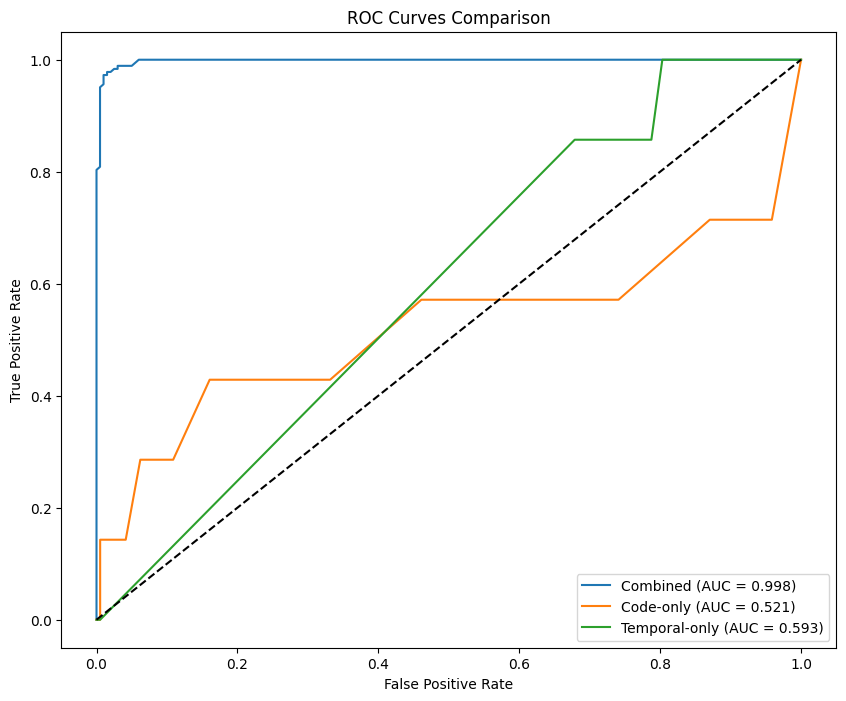


ROC curve comparison saved to 'roc_comparison.png'


In [21]:
plt.figure(figsize=(10, 8))

for name, clf, X_test, y_test in [
    ('Combined', clf_combined, X_combined_test, y_combined_test),
    ('Code-only', clf_code, X_code_test, y_code_test),
    ('Temporal-only', clf_temporal, X_temporal_test, y_temporal_test)
]:
    y_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_score):.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.savefig('roc_comparison.png')
plt.show()

print("\nROC curve comparison saved to 'roc_comparison.png'")